# Cyberbullying On Social Media

# XGBoost

In [1]:
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt  
import seaborn as sns


from sklearn.metrics import f1_score
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.pipeline import Pipeline
from sklearn import metrics
from sklearn.metrics import classification_report
from sklearn.metrics import f1_score, roc_auc_score, roc_curve

import imblearn
# print(imblearn.__version__)
from imblearn.over_sampling import SMOTE

# !pip install xgboost

import xgboost as xgb
from xgboost import XGBClassifier
from xgboost import plot_tree

import warnings
warnings.filterwarnings('ignore')
warnings.simplefilter('ignore')

In [2]:
df = pd.read_csv('labeled_insta_cleaned.csv', encoding = 'utf-8-sig', engine = 'python')

In [3]:
comments = df['tidy_text']
labels = df['label_bullying']

In [4]:
#keep the same random state for reproducibility
RANDOM_STATE = 12
TRAIN_TEST_SPLIT_SIZE = .1
VALIDATION_SPLIT_SIZE = .2

**XGBoost**

Extreme Gradient Boosting (xgboost) is an advanced implementation of the gradient boosting algorithm. It has both linear model solver and tree learning algorithms. Its ability to do parallel computation on a single machine makes it extremely fast. 

Some key benefits of XGBoost are:

- Regularization - helps in reducing overfitting

- Parallel Processing - XGBoost implements parallel processing and is blazingly faster as compared to GBM.

- Handling Missing Values - It has an in-built routine to handle missing values.

- Built-in Cross-Validation - allows user to run a cross-validation at each iteration of the boosting process


For this part I will perform the following steps:
- Evaluate the XGBoost model for the different word embeddings
- Tune the regularization strength parameter with cross-validated grid-search for each type of embeddings
- Check the predictions against the actual values
- Compare the results for the different word embeddings

**Hyperparameter Tuning**

XGBoost has quite a many tuning parameters and sometimes it becomes tricky to properly tune them. I used these guides for ideas on how to tune the model:

https://www.analyticsvidhya.com/blog/2016/03/complete-guide-parameter-tuning-xgboost-with-codes-python/
https://blog.cambridgespark.com/hyperparameter-tuning-in-xgboost-4ff9100a3b2f
https://towardsdatascience.com/fine-tuning-xgboost-in-python-like-a-boss-b4543ed8b1e

**Quick note on the method**

In an ideal world, with infinite resources and where time is not an issue, I could run a giant grid search with all the parameters together and find the optimal solution. In fact, I gave it a try: using TFIDF I managed to find the optimal parameters after about 8 hours. For Word2Vec and using the same searh space as here I had to give up after 20 hours. Perhaps it is still doable with really small datasets, but for this dataset (which is by far not the largest), the training time was growing exponentially, and each step in the tuning process was becoming more and more expensive. 

In practice this approach is rarely feasible, so instead I'll go through the parameters one or two at a time. After careful reading, I decided to tune 5 of the hyperparameters that usually have a big impact on the performance. In theory it would be necessary to test all combinations to ensure we find THE optimal solution, but here I will try to find a good enough one by improving the model with a reasonable number of steps.

I somehow wanted to still give it a try using GridSearchCV as well, so I decided to try using a smaller search space. Interestingly enough, although the parameters I found here by manual trials were in the search space, GridSearchCV found different best parameters. Even though the parameters found were different, the results are the same. This tells us that tuning the parameters has little influence on the results, and the quality of the results is mostly influenced by the size and quality of the data set, and there isn't much more that can be done to improve these results.


**Approach for Parameter Tuning**

- Choose a relatively high learning rate. The default learning rate of 0.3 used at this stage. 

- Tune tree-specific parameters such as max_depth, min_child_weight, subsample, colsample_bytree keeping the learning rate fixed.

- Tune the learning rate.

- Finally tune gamma to avoid overfitting (optional).

- Determine the optimum number of trees. XGBoost also has its own cv function which performs cross-validation at each boosting iteration and returns the optimum number of trees required. I will set a very high number of trees (or num_boost_round in XGBoost terminology and rely on early stopping.

**Using XGBoost’s CV**

In order to tune the hyperparameters, I will use the cv function from XGBoost. It allows  to run cross-validation on the training dataset and returns a score (either built-in or customly defined).
It requires the following inputs:
- params: dictionary of parameters.
- dtrain matrix.
- num_boost_round: number of boosting rounds. Here I will use a large number and count on early_stopping_rounds to find the optimal number of rounds before reaching the maximum.
- seed: random seed. It's important to set a seed here, to ensure we are using the same folds for each step so we can properly compare the scores with different parameters.
- nfold: the number of folds to use for cross-validation. Setting this to 5, same as for the other classifiers.
- metrics: the metrics to use to evaluate the model. For this part I have defined a custom F1 score metric, since XGBoost does not have one natively, and I wanted to compare to other classifiers using the same metric.


**A note about num_boost_round and early_stopping_rounds**

XGBoost is a gradient boosting method, as such it adds trees in every iteration to improve the prediction accuracy (performance). 

The prediction performance increases when you add more and more trees until it starts to overfit, at which point the it will start to decrease. So we need to find that optimum number of trees. It is basically impossible to guess this number, and this is what XGBoost.cv is for. It partitions the training data into two subsets. The first subset is used to train XGBoost, the second is used as a validation set. After each iteration (which adds an additional tree) XGBoost calculates the new validation error. With that XGBoost is able to detect when it starts to overfit (when the chosen evaluation metric starts to either increase (loss), or decrease (our custom F1 score)). This will give us the optimal number of trees for a given set of hyperparameters.

The num_boost_rounds (number of trees) parameter is not part of the PARAMETERS dictionary, but it is also a tunable parameter. num_boost_round corresponds to the number of boosting rounds or trees to build. Its optimal value highly depends on the other parameters. This means it should be re-tuned each time we update a parameter. I could do this by tuning it together with all parameters in the grid-search, but it requires a lot of computational effort. Fortunately XGBoost provides a nice way to find the best number of rounds while training. Since trees are built sequentially, instead of fixing the number of rounds at the beginning, we can test our model at each step and see if adding a new tree/boost round improves performance. If the performance hasn’t improved for a specific number of rounds (as defined by the variable early_stopping_round), we stop the training and keep the best number of boosting rounds. 


I've decided here to use the XGBoost algorithm directly for tuning (mostly because it makes cross validation easy), there is also a scikit learn wrapper around XGBoost called XGBRegressor. The XGBoost algorithm is more customizeable, but the scikit learn wrapper plays more nicely with pipelines (and doesn't need DMatrix input).

***

**Utility Functions**

***

In [5]:
def custom_f1_score(preds, d_train):
    labels = d_train.get_label().astype(np.int)
    preds = (preds >= 0.5).astype(np.int)
    return [('f1_score', f1_score(labels, preds))]

In [6]:
# setup color scheme and standard figure size for all figures
mpl.rcParams['figure.figsize'] = (12, 10)
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

In [7]:
def plot_cfm(labels, predictions, p = 0.5):
    cfm = metrics.confusion_matrix(labels, predictions > p)
    plt.figure(figsize = (5,5))
    sns.heatmap(cfm, annot = True, fmt = "d")
    plt.title('Confusion matrix @{:.2f}'.format(p))
    plt.ylabel('Actual values')
    plt.xlabel('Predicted values')

    print('True Negatives: ', cfm[0][0])
    print('False Positives: ', cfm[0][1])
    print('False Negatives: ', cfm[1][0])
    print('True Positives: ', cfm[1][1])

In [8]:
def plot_roc(name, labels, predictions, **kwargs):
    fp, tp, _ = roc_curve(labels, predictions)
    roc_auc = metrics.auc(fp, tp)    
    plt.title('Receiver Operating Characteristic')
    plt.plot(fp, tp, label = name + ' AUC = %0.2f' % roc_auc, linewidth=2, **kwargs)
    plt.legend(loc = 'lower right')
    plt.plot([0, 1], [0, 1], linewidth=2, color=colors[6], linestyle=':')
    plt.xlabel('False positives [%]')
    plt.ylabel('True positives [%]')
    plt.grid(True)
    ax = plt.gca()
    ax.set_aspect('equal')

In [9]:
def init_params():
#     Initialize with default parameters
    PARAMETERS['max_depth'] = 6
    PARAMETERS['min_child_weight'] = 1
    PARAMETERS['eta'] = .3
    PARAMETERS['subsample'] = 1
    PARAMETERS['colsample_bytree'] = 1
    return PARAMETERS

In [10]:
def cross_validation(PARAMETERS, d_train):
    cv_results = xgb.cv(PARAMETERS,
        d_train,
        feval = custom_f1_score,
        num_boost_round = NUM_BOOST_ROUNDS,
        maximize = True,
        seed = RANDOM_SEED,
        nfold = 5,
        early_stopping_rounds = EARLY_STOPPING_ROUNDS
    )
    return cv_results

***

**TF-IDF**

***

**Prepare the data set and DMatrices**

Notice that here we will use the training features which have already been upsampled using SMOTE.

In [11]:
train_tfidf_features = np.load('train_dataset_tfidf_features.npy', allow_pickle=True)
train_tfidf_labels = np.load('train_dataset_tfidf_labels.npy', allow_pickle=True)

In [12]:
test_tfidf_features = np.load('test_dataset_tfidf_features.npy', allow_pickle=True)
test_tfidf_labels = np.load('test_dataset_tfidf_labels.npy', allow_pickle=True)

In [13]:
val_tfidf_features = np.load('val_dataset_tfidf_features.npy', allow_pickle=True)
val_tfidf_labels = np.load('val_dataset_tfidf_labels.npy', allow_pickle=True)

In [14]:
# Create X/y arrays
x_train_tfidf = train_tfidf_features.item()
y_train_tfidf = train_tfidf_labels

print('x:', x_train_tfidf.shape, x_train_tfidf.dtype)
print('y:', y_train_tfidf.shape, y_train_tfidf.dtype)

x: (11304, 1000) float64
y: (11304,) int64


In [15]:
# Create X/y arrays
x_test_tfidf = test_tfidf_features.item()
y_test_tfidf = test_tfidf_labels

print('x:', x_test_tfidf.shape, x_test_tfidf.dtype)
print('y:', y_test_tfidf.shape, y_test_tfidf.dtype)

x: (1104, 1000) float64
y: (1104,) int64


In [16]:
# Create X/y arrays
x_val_tfidf = val_tfidf_features.item()
y_val_tfidf = val_tfidf_labels

print('x:', x_val_tfidf.shape, x_val_tfidf.dtype)
print('y:', y_val_tfidf.shape, y_val_tfidf.dtype)

x: (1986, 1000) float64
y: (1986,) int64


Instead of numpy arrays or pandas data frames, XGBoost uses DMatrices. A DMatrix can contain both the features and the target. The data is already loaded into arrays, so I can use them to create the DMatrix. 

In [17]:
# A DMatrix can contain both the features and the target.
d_train_tfidf = xgb.DMatrix(x_train_tfidf, label = y_train_tfidf) 
d_test_tfidf = xgb.DMatrix(x_test_tfidf, label = y_test_tfidf)
d_val_tfidf = xgb.DMatrix(x_val_tfidf, label = y_val_tfidf)
watchlist_tfidf = [(d_train_tfidf, 'train'), (d_val_tfidf, 'val')]

In [18]:
# Initialize with default parameters
PARAMETERS = {
     'objective':'binary:logistic',
     'max_depth': 6,
     'min_child_weight': 1,
     'eta': .3,
     'subsample': 1,
     'colsample_bytree': 1
  }

In [19]:
RANDOM_SEED = 12
NUM_BOOST_ROUNDS = 1000
EARLY_STOPPING_ROUNDS = 20

**Tune max_depth and min_child_weight** 

I'll tune these concurrently using a basic grid search, meaning I'll test all combinations of the two variables in a certain range. Whichever combination has the best cross validation score, will be set as values for the next round.


- max_depth is the largest depth allowed on any decision tree in the ensemble, where tree depth is the number of nodes from the root down to the farthest away leaf. Larger max_depth values allow for more complex trees, which means a larger chance of capturing complicated features but also a larger chance of overfitting.
- min_child_weight is a regularization factor that changes how often tree nodes split in tree creation. Only nodes with a hessian (second order partial derivative) larger than min_child_weight are allowed to split. Smaller min_child_weight values mean more complex trees, and therefore more chance of overfitting.

In [20]:
# Tune max_depth and min_child_weight
gs_space = [
    (max_depth, min_child_weight)
    for max_depth in range(3,10,2)
        for min_child_weight in range(1,6,2)
]
max_f1 = 0. # initializing with 0 
best_params = None 
for max_depth, min_child_weight in gs_space:
    print("Performing cross validation for parameters max_depth = {}, min_child_weight = {}".format(max_depth, min_child_weight))
    
    # Update parameters
    PARAMETERS['max_depth'] = max_depth
    PARAMETERS['min_child_weight'] = min_child_weight
    
    # Run cross validation
    cv_results = cross_validation(PARAMETERS, d_train_tfidf)
    
    # Find best F1 Score
    mean_f1 = cv_results['test-f1_score-mean'].max()
    
    boost_rounds = np.argmax(cv_results['test-f1_score-mean'])    
    print("\tF1 Score {} reached after {} rounds".format(mean_f1, boost_rounds))    
    if mean_f1 > max_f1:
        max_f1 = mean_f1
        best_params = (max_depth, min_child_weight) 

print("Best params: {}, {}, F1 Score: {}".format(best_params[0], best_params[1], max_f1))

Performing cross validation for parameters max_depth = 3, min_child_weight = 1
	F1 Score 0.7344211999999999 reached after 202 rounds
Performing cross validation for parameters max_depth = 3, min_child_weight = 3
	F1 Score 0.7418172 reached after 355 rounds
Performing cross validation for parameters max_depth = 3, min_child_weight = 5
	F1 Score 0.7276526 reached after 154 rounds
Performing cross validation for parameters max_depth = 5, min_child_weight = 1
	F1 Score 0.7491482000000002 reached after 202 rounds
Performing cross validation for parameters max_depth = 5, min_child_weight = 3
	F1 Score 0.741549 reached after 198 rounds
Performing cross validation for parameters max_depth = 5, min_child_weight = 5
	F1 Score 0.7333841999999999 reached after 125 rounds
Performing cross validation for parameters max_depth = 7, min_child_weight = 1
	F1 Score 0.7554122 reached after 196 rounds
Performing cross validation for parameters max_depth = 7, min_child_weight = 3
	F1 Score 0.73979 reached a

In [21]:
# Update max_depth and min_child_weight parameters.
PARAMETERS['max_depth'] = best_params[0]
PARAMETERS['min_child_weight'] = best_params[1]

**Tune subsample and colsample**

- subsample is the fraction of datapoints (rows of the training data) to sample at each round (each tree), with 0 meaning no rows are sampled and 1 meaning all rows are sampled. The higher the value, the more likely to overfit the data.
- colsample_bytree is the fraction of features (columns of the training data) to sample at each round (each tree), with 0 meaning no columns are sampled and 1 meaning all columns are sampled. The higher the value, the more likely to overfit the data.

In [22]:
# Tuning subsample and colsample
gs_space = [
    (subsample, colsample_bytree)
    for subsample in [i/10. for i in range(5,10)]
    for colsample_bytree in [i/10. for i in range(5,10)] 
]
max_f1 = 0. 
best_params = None 
for subsample, colsample_bytree in gs_space:
    print("Performing cross validation for parameters subsample = {}, colsample_bytree = {}".format(subsample, colsample_bytree))
    
    # Update parameters
    PARAMETERS['colsample_bytree'] = colsample_bytree
    PARAMETERS['subsample'] = subsample
    
    # Run cross validation
    cv_results = cross_validation(PARAMETERS, d_train_tfidf)

    # Find best F1 Score
    mean_f1 = cv_results['test-f1_score-mean'].max()
    boost_rounds = np.argmax(cv_results['test-f1_score-mean'])    
    print("\tF1 Score {} reached after {} rounds".format(mean_f1, boost_rounds))
    if mean_f1 > max_f1:
        max_f1 = mean_f1
        best_params = (subsample, colsample_bytree) 

print("Best params: {}, {}, F1 Score: {}".format(best_params[0], best_params[1], max_f1))

Performing cross validation for parameters subsample = 0.5, colsample_bytree = 0.5
	F1 Score 0.731029 reached after 55 rounds
Performing cross validation for parameters subsample = 0.5, colsample_bytree = 0.6
	F1 Score 0.7408 reached after 92 rounds
Performing cross validation for parameters subsample = 0.5, colsample_bytree = 0.7
	F1 Score 0.7437509999999999 reached after 139 rounds
Performing cross validation for parameters subsample = 0.5, colsample_bytree = 0.8
	F1 Score 0.743267 reached after 106 rounds
Performing cross validation for parameters subsample = 0.5, colsample_bytree = 0.9
	F1 Score 0.7427072 reached after 134 rounds
Performing cross validation for parameters subsample = 0.6, colsample_bytree = 0.5
	F1 Score 0.737936 reached after 85 rounds
Performing cross validation for parameters subsample = 0.6, colsample_bytree = 0.6
	F1 Score 0.7458592 reached after 107 rounds
Performing cross validation for parameters subsample = 0.6, colsample_bytree = 0.7
	F1 Score 0.7442572 r

In [23]:
# Update subsample and colsample_bytree
PARAMETERS['subsample'] = best_params[0]
PARAMETERS['colsample_bytree'] = best_params[1]

**Tune eta**

Eta in XGBoost works the same way as a learning_rate, in the sense that it controls how quickly each step changes. The smaller the eta, the smaller each step, which means the algorithm will likely take more steps to converge.

In [24]:
# Tune the learning rate.
max_f1 = 0. 
best_params = None 
for eta in [.3, .2, .1, .05, .01, .005]:
    print("Performing cross validation for parameter eta = {}".format(eta))
    
    # Update ETA
    PARAMETERS['eta'] = eta
    
    # Run cross validation
    cv_results = cross_validation(PARAMETERS, d_train_tfidf)

    # Find best F1 Score
    mean_f1 = cv_results['test-f1_score-mean'].max()
    boost_rounds = np.argmax(cv_results['test-f1_score-mean'])    
    print("\tF1 Score {} reached after {} rounds".format(mean_f1, boost_rounds))
    if mean_f1 > max_f1:
        max_f1 = mean_f1
        best_params = eta 
print("Best params: {}, F1 Score: {}".format(best_params, max_f1))

Performing cross validation for parameter eta = 0.3
	F1 Score 0.7586228 reached after 175 rounds
Performing cross validation for parameter eta = 0.2
	F1 Score 0.7633306 reached after 257 rounds
Performing cross validation for parameter eta = 0.1
	F1 Score 0.7492773999999999 reached after 181 rounds
Performing cross validation for parameter eta = 0.05
	F1 Score 0.7478846000000001 reached after 292 rounds
Performing cross validation for parameter eta = 0.01
	F1 Score 0.6331840000000001 reached after 11 rounds
Performing cross validation for parameter eta = 0.005
	F1 Score 0.6344196 reached after 11 rounds
Best params: 0.2, F1 Score: 0.7633306


In [25]:
# Update eta.
PARAMETERS['eta'] = best_params

Let’s have a look at the final list of tuned parameters.

In [26]:
PARAMETERS

{'objective': 'binary:logistic',
 'max_depth': 9,
 'min_child_weight': 1,
 'eta': 0.2,
 'subsample': 0.9,
 'colsample_bytree': 0.9}

Finally I can now use these tuned parameters in the xgboost model. I will set a very high num_boost_round and rely on early stopping to stop the model if its performance doesn’t improve in 20 rounds.

In [27]:
xgb_model = xgb.train(
    PARAMETERS,
    d_train_tfidf,
    feval = custom_f1_score,
    num_boost_round = NUM_BOOST_ROUNDS,
    maximize = True,
    evals = watchlist_tfidf,
    early_stopping_rounds = EARLY_STOPPING_ROUNDS, 
    verbose_eval=True)

[0]	train-error:0.33086	val-error:0.31470	train-f1_score:0.57981	val-f1_score:0.36493
Multiple eval metrics have been passed: 'val-f1_score' will be used for early stopping.

Will train until val-f1_score hasn't improved in 20 rounds.
[1]	train-error:0.29618	val-error:0.31118	train-f1_score:0.63961	val-f1_score:0.37322
[2]	train-error:0.27681	val-error:0.30765	train-f1_score:0.66581	val-f1_score:0.37843
[3]	train-error:0.27247	val-error:0.30463	train-f1_score:0.67338	val-f1_score:0.39439
[4]	train-error:0.26937	val-error:0.30715	train-f1_score:0.67692	val-f1_score:0.39122
[5]	train-error:0.25690	val-error:0.30614	train-f1_score:0.69566	val-f1_score:0.40158
[6]	train-error:0.25027	val-error:0.29909	train-f1_score:0.70669	val-f1_score:0.41765
[7]	train-error:0.24531	val-error:0.29859	train-f1_score:0.71690	val-f1_score:0.43470
[8]	train-error:0.23894	val-error:0.30060	train-f1_score:0.72593	val-f1_score:0.43089
[9]	train-error:0.23487	val-error:0.30413	train-f1_score:0.73125	val-f1_score

In [28]:
# XGBoost returns probabilities by default.
y_probas_train_tfidf = xgb_model.predict(d_train_tfidf)
y_probas_test_tfidf = xgb_model.predict(d_test_tfidf)

In [29]:
y_pred_test_tfidf = np.round(y_probas_test_tfidf)

True Negatives:  610
False Positives:  175
False Negatives:  169
True Positives:  150


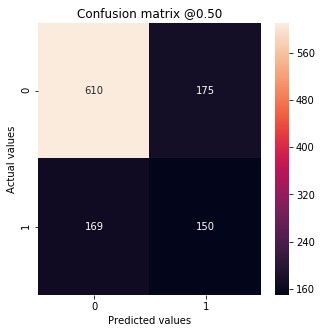

In [30]:
plot_cfm(y_test_tfidf, y_probas_test_tfidf)

In [31]:
print(classification_report(y_test_tfidf, y_pred_test_tfidf))

              precision    recall  f1-score   support

           0       0.78      0.78      0.78       785
           1       0.46      0.47      0.47       319

    accuracy                           0.69      1104
   macro avg       0.62      0.62      0.62      1104
weighted avg       0.69      0.69      0.69      1104



Compared to the other models, which seemed to concentrate on maximing either one of precision or recall, at the cost of the other, XGBoost achieves similar scores for both precision and recall (for both classes).


The XGBoost model got 78% of the test set majority class right, but struggles to recognize the minority class (bullying comments), with only 150 comments predicted correctly.

In [32]:
f1_tfidf = f1_score(y_test_tfidf, y_pred_test_tfidf, average='weighted')
print('TFDIF F1: %.2f' % f1_tfidf)

TFDIF F1: 0.69


In [33]:
auc_tfidf = roc_auc_score(y_test_tfidf, y_probas_test_tfidf)
print('TFIDF AUC: %.2f' % auc_tfidf)

TFIDF AUC: 0.69


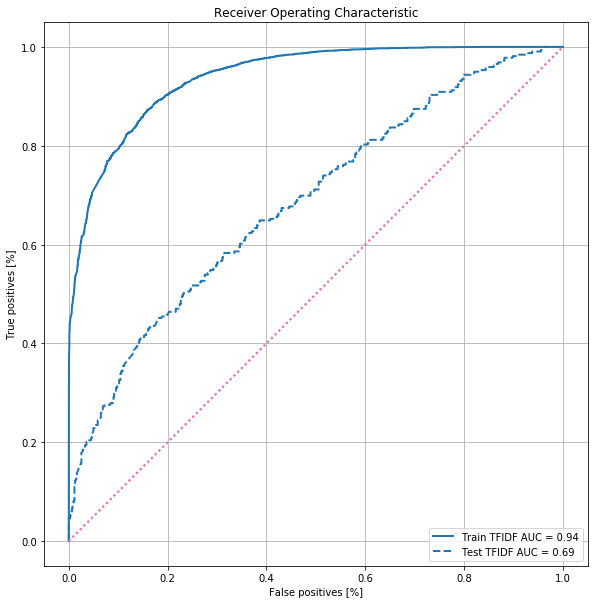

In [34]:
plot_roc("Train TFIDF", y_train_tfidf, y_probas_train_tfidf, color = colors[0])
plot_roc("Test TFIDF", y_test_tfidf, y_probas_test_tfidf, color = colors[0], linestyle = '--')

Interestingly enough, compared to the other models where the train and test curves followed a similar curve, XGBoost seems to achieve an extremely good ROC AUC curve for the training data, but fails to generalize for the test data. 

***

**Word2Vec**

***

Apply the same steps for the Word2Vec vectors.

**Prepare the datasets**

Preparing the datasets here also needs to account for the train-validation-test split, as well as applying SMOTE to the training data only.

In [35]:
w2v_features = np.load('w2v_features.npy', allow_pickle=True)

In [36]:
# Create X/y arrays
comments_w2v = w2v_features
labels_w2v = labels
print('x:', comments_w2v.shape, comments_w2v.dtype) 
print('y:', labels_w2v.shape, labels_w2v.dtype)

x: (11033, 100) float64
y: (11033,) int64


In [37]:
x_train_val_w2v, x_test_w2v, y_train_val_w2v, y_test_w2v = train_test_split(comments_w2v, labels_w2v,
                                                  test_size = TRAIN_TEST_SPLIT_SIZE, stratify = labels_w2v,
                                                  random_state = RANDOM_STATE)

In [38]:
x_train_w2v, x_val_w2v, y_train_w2v, y_val_w2v = train_test_split(x_train_val_w2v, y_train_val_w2v,
                                                  test_size = VALIDATION_SPLIT_SIZE, stratify = y_train_val_w2v,
                                                  random_state = RANDOM_STATE)

In [39]:
# transform the training dataset only.
sm = SMOTE(random_state = RANDOM_STATE)
x_train_w2v_sm, y_train_w2v_sm = sm.fit_sample(x_train_w2v, y_train_w2v)

In [40]:
# A DMatrix can contain both the features and the target.
d_train_w2v = xgb.DMatrix(x_train_w2v_sm, label = y_train_w2v_sm) 
d_test_w2v = xgb.DMatrix(x_test_w2v, label = y_test_w2v)
d_val_w2v = xgb.DMatrix(x_val_w2v, label = y_val_w2v)
watchlist_w2v = [(d_train_w2v, 'train'), (d_val_w2v, 'val')]

In [41]:
# initialize parameters to default values
init_params()

{'objective': 'binary:logistic',
 'max_depth': 6,
 'min_child_weight': 1,
 'eta': 0.3,
 'subsample': 1,
 'colsample_bytree': 1}

In [42]:
# Tune max_depth and min_child_weight
gs_space = [
    (max_depth, min_child_weight)
    for max_depth in range(3,10,2)
        for min_child_weight in range(1,6,2)
]
max_f1 = 0. # initializing with 0 
best_params = None 
for max_depth, min_child_weight in gs_space:
    print("Performing cross validation for parameters max_depth = {}, min_child_weight = {}".format(max_depth, min_child_weight))
    
    # Update  parameters
    PARAMETERS['max_depth'] = max_depth
    PARAMETERS['min_child_weight'] = min_child_weight
    
    # Run cross validation
    cv_results = cross_validation(PARAMETERS, d_train_w2v)

    # Find best F1 Score
    mean_f1 = cv_results['test-f1_score-mean'].max()
    
    boost_rounds = np.argmax(cv_results['test-f1_score-mean'])    
    print("\tF1 Score {} reached after {} rounds".format(mean_f1, boost_rounds))    
    if mean_f1 > max_f1:
        max_f1 = mean_f1
        best_params = (max_depth, min_child_weight) 

print("Best params: {}, {}, F1 Score: {}".format(best_params[0], best_params[1], max_f1))

Performing cross validation for parameters max_depth = 3, min_child_weight = 1
	F1 Score 0.7518264 reached after 267 rounds
Performing cross validation for parameters max_depth = 3, min_child_weight = 3
	F1 Score 0.7648468 reached after 428 rounds
Performing cross validation for parameters max_depth = 3, min_child_weight = 5
	F1 Score 0.7599676 reached after 342 rounds
Performing cross validation for parameters max_depth = 5, min_child_weight = 1
	F1 Score 0.8076508 reached after 333 rounds
Performing cross validation for parameters max_depth = 5, min_child_weight = 3
	F1 Score 0.800615 reached after 283 rounds
Performing cross validation for parameters max_depth = 5, min_child_weight = 5
	F1 Score 0.7985990000000001 reached after 214 rounds
Performing cross validation for parameters max_depth = 7, min_child_weight = 1
	F1 Score 0.8165804 reached after 162 rounds
Performing cross validation for parameters max_depth = 7, min_child_weight = 3
	F1 Score 0.8113642000000001 reached after 22

In [43]:
# Update max_depth and min_child_weight parameters.
PARAMETERS['max_depth'] = best_params[0]
PARAMETERS['min_child_weight'] = best_params[1]

In [44]:
# Tune subsample and colsample
gs_space = [
    (subsample, colsample_bytree)
    for subsample in [i/10. for i in range(5,10)]
    for colsample_bytree in [i/10. for i in range(5,10)] 
]
max_f1 = 0. 
best_params = None 
for subsample, colsample_bytree in gs_space:
    print("Performing cross validation for parameters subsample = {}, colsample_bytree = {}".format(subsample, colsample_bytree))
    
    # Update parameters
    PARAMETERS['colsample_bytree'] = colsample_bytree
    PARAMETERS['subsample'] = subsample

    # Run cross validation
    cv_results = cross_validation(PARAMETERS, d_train_w2v)

    # Find best F1 Score
    mean_f1 = cv_results['test-f1_score-mean'].max()
    boost_rounds = np.argmax(cv_results['test-f1_score-mean'])    
    print("\tF1 Score {} reached after {} rounds".format(mean_f1, boost_rounds))
    if mean_f1 > max_f1:
        max_f1 = mean_f1
        best_params = (subsample, colsample_bytree) 

print("Best params: {}, {}, F1 Score: {}".format(best_params[0], best_params[1], max_f1))

Performing cross validation for parameters subsample = 0.5, colsample_bytree = 0.5
	F1 Score 0.80381 reached after 208 rounds
Performing cross validation for parameters subsample = 0.5, colsample_bytree = 0.6
	F1 Score 0.8002238 reached after 187 rounds
Performing cross validation for parameters subsample = 0.5, colsample_bytree = 0.7
	F1 Score 0.80555 reached after 198 rounds
Performing cross validation for parameters subsample = 0.5, colsample_bytree = 0.8
	F1 Score 0.8000672 reached after 128 rounds
Performing cross validation for parameters subsample = 0.5, colsample_bytree = 0.9
	F1 Score 0.7955722000000001 reached after 108 rounds
Performing cross validation for parameters subsample = 0.6, colsample_bytree = 0.5
	F1 Score 0.804864 reached after 135 rounds
Performing cross validation for parameters subsample = 0.6, colsample_bytree = 0.6
	F1 Score 0.7978736000000001 reached after 108 rounds
Performing cross validation for parameters subsample = 0.6, colsample_bytree = 0.7
	F1 Scor

In [45]:
# Update subsample and colsample_bytree
PARAMETERS['subsample'] = best_params[0]
PARAMETERS['colsample_bytree'] = best_params[1]

In [46]:
# Tune the learning rate.
max_f1 = 0. 
best_params = None 
for eta in [.3, .2, .1, .05, .01, .005]:
    print("Performing cross validation for parameter eta = {}".format(eta))
    
    # Update ETA
    PARAMETERS['eta'] = eta

    # Run cross validation
    cv_results = cross_validation(PARAMETERS, d_train_w2v)

    # Find best F1 Score
    mean_f1 = cv_results['test-f1_score-mean'].max()
    boost_rounds = np.argmax(cv_results['test-f1_score-mean'])    
    print("\tF1 Score {} reached after {} rounds".format(mean_f1, boost_rounds))
    if mean_f1 > max_f1:
        max_f1 = mean_f1
        best_params = eta 
print("Best params: {}, F1 Score: {}".format(best_params, max_f1))

Performing cross validation for parameter eta = 0.3
	F1 Score 0.8216514 reached after 212 rounds
Performing cross validation for parameter eta = 0.2
	F1 Score 0.8266275999999999 reached after 254 rounds
Performing cross validation for parameter eta = 0.1
	F1 Score 0.8295769999999999 reached after 282 rounds
Performing cross validation for parameter eta = 0.05
	F1 Score 0.8270854 reached after 245 rounds
Performing cross validation for parameter eta = 0.01
	F1 Score 0.8177808000000001 reached after 509 rounds
Performing cross validation for parameter eta = 0.005
	F1 Score 0.8108016000000001 reached after 806 rounds
Best params: 0.1, F1 Score: 0.8295769999999999


In [47]:
# Update eta.
PARAMETERS['eta'] = best_params

In [48]:
PARAMETERS

{'objective': 'binary:logistic',
 'max_depth': 9,
 'min_child_weight': 1,
 'eta': 0.1,
 'subsample': 0.9,
 'colsample_bytree': 0.7}

In [49]:
xgb_model = xgb.train(
    PARAMETERS,
    d_train_w2v,
    feval = custom_f1_score,
    num_boost_round = NUM_BOOST_ROUNDS,
    maximize = True,
    evals = watchlist_w2v,
    early_stopping_rounds = EARLY_STOPPING_ROUNDS, 
    verbose_eval = True)

[0]	train-error:0.20718	val-error:0.40987	train-f1_score:0.80405	val-f1_score:0.44326
Multiple eval metrics have been passed: 'val-f1_score' will be used for early stopping.

Will train until val-f1_score hasn't improved in 20 rounds.
[1]	train-error:0.15764	val-error:0.36355	train-f1_score:0.84388	val-f1_score:0.46039
[2]	train-error:0.13048	val-error:0.34592	train-f1_score:0.87083	val-f1_score:0.46537
[3]	train-error:0.11651	val-error:0.32477	train-f1_score:0.88460	val-f1_score:0.49570
[4]	train-error:0.10412	val-error:0.32780	train-f1_score:0.89689	val-f1_score:0.47962
[5]	train-error:0.09183	val-error:0.31823	train-f1_score:0.90904	val-f1_score:0.48701
[6]	train-error:0.08307	val-error:0.32024	train-f1_score:0.91752	val-f1_score:0.48208
[7]	train-error:0.07953	val-error:0.30715	train-f1_score:0.92111	val-f1_score:0.50082
[8]	train-error:0.07236	val-error:0.31218	train-f1_score:0.92830	val-f1_score:0.48760
[9]	train-error:0.06953	val-error:0.30111	train-f1_score:0.93115	val-f1_score

In [50]:
y_probas_train_w2v = xgb_model.predict(d_train_w2v)
y_probas_test_w2v = xgb_model.predict(d_test_w2v)

In [51]:
y_pred_test_w2v = np.round(y_probas_test_w2v)

True Negatives:  638
False Positives:  147
False Negatives:  181
True Positives:  138


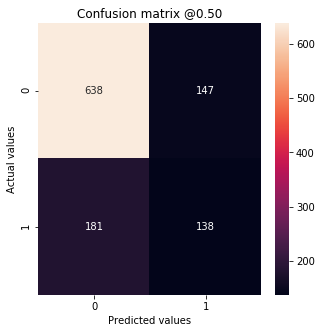

In [52]:
plot_cfm(y_test_w2v, y_probas_test_w2v)

In [53]:
print(classification_report(y_test_w2v, y_pred_test_w2v))

              precision    recall  f1-score   support

           0       0.78      0.81      0.80       785
           1       0.48      0.43      0.46       319

    accuracy                           0.70      1104
   macro avg       0.63      0.62      0.63      1104
weighted avg       0.69      0.70      0.70      1104



Using word embedding vectors, XGBoost manages to identify a bit more 0's as 0's (620 versus 610), but a bit less 1's as 1's (138 versus 150), achieving overall very similar score to XGBoost with TF-IDF.

In [54]:
f1_w2v = f1_score(y_test_w2v, y_pred_test_w2v, average='weighted')
print('W2V F1: %.2f' % f1_w2v)

W2V F1: 0.70


In [55]:
auc_w2v = roc_auc_score(y_test_w2v, y_probas_test_w2v)
print('W2V AUC: %.2f' % auc_w2v)

W2V AUC: 0.68


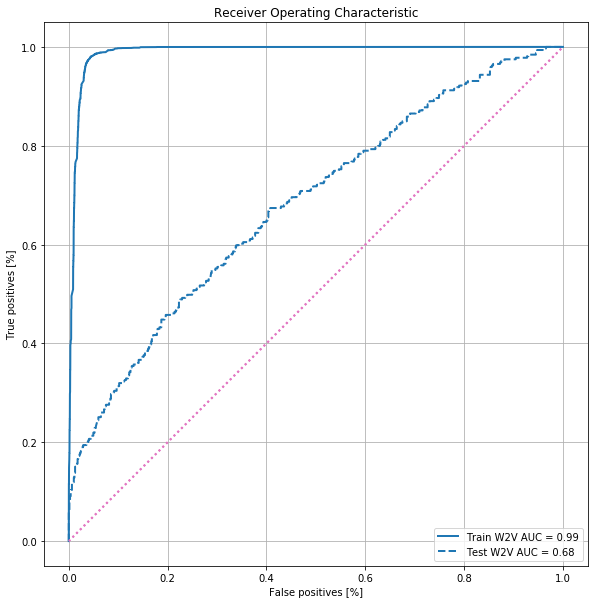

In [56]:
plot_roc("Train W2V", y_train_w2v_sm, y_probas_train_w2v, color = colors[0])
plot_roc("Test W2V", y_test_w2v, y_probas_test_w2v, color = colors[0], linestyle='--')

Here we notice a similar behaviour as for the TF-IDF features: XGBoost seems to achieve an almost perfect ROC AUC curve for the training data, but fails to generalize for the test data.

***

**Glove/FastText Embeddings**

***

In [57]:
gft_features = np.load('gloveft_features.npy', allow_pickle=True)

In [58]:
# Create X/y arrays
comments_gft = gft_features
labels_gft = labels
print('x:', comments_gft.shape, comments_gft.dtype) 
print('y:', labels_gft.shape, labels_gft.dtype)

x: (11033, 100) float64
y: (11033,) int64


In [59]:
x_train_val_gft, x_test_gft, y_train_val_gft, y_test_gft = train_test_split(comments_gft, labels_gft,
                                                  test_size = TRAIN_TEST_SPLIT_SIZE, stratify = labels_gft,
                                                  random_state = RANDOM_STATE)

In [60]:
x_train_gft, x_val_gft, y_train_gft, y_val_gft = train_test_split(x_train_val_gft, y_train_val_gft,
                                                  test_size = VALIDATION_SPLIT_SIZE, stratify = y_train_val_gft,
                                                  random_state = RANDOM_STATE)

In [61]:
# transform the training dataset only
sm = SMOTE(random_state = RANDOM_STATE)
x_train_gft_sm, y_train_gft_sm = sm.fit_sample(x_train_gft, y_train_gft)

In [62]:
# A DMatrix can contain both the features and the target.
d_train_gft = xgb.DMatrix(x_train_gft_sm, label = y_train_gft_sm) 
d_test_gft = xgb.DMatrix(x_test_gft, label = y_test_gft)
d_val_gft = xgb.DMatrix(x_val_gft, label = y_val_gft)
watchlist_gft = [(d_train_gft, 'train'), (d_val_gft, 'val')]

In [63]:
# initialize parameters to default values
init_params()

{'objective': 'binary:logistic',
 'max_depth': 6,
 'min_child_weight': 1,
 'eta': 0.3,
 'subsample': 1,
 'colsample_bytree': 1}

In [64]:
# Tune max_depth and min_child_weight
gs_space = [
    (max_depth, min_child_weight)
    for max_depth in range(3,10,2)
        for min_child_weight in range(1,6,2)
]
max_f1 = 0. # initializing with 0 
best_params = None 
for max_depth, min_child_weight in gs_space:
    print("Performing cross validation for parameters max_depth = {}, min_child_weight = {}".format(max_depth, min_child_weight))
    
    # Update parameters
    PARAMETERS['max_depth'] = max_depth
    PARAMETERS['min_child_weight'] = min_child_weight

    # Run cross validation
    cv_results = cross_validation(PARAMETERS, d_train_gft)

    # Find best F1 Score
    mean_f1 = cv_results['test-f1_score-mean'].max()
    
    boost_rounds = np.argmax(cv_results['test-f1_score-mean'])    
    print("\tF1 Score {} reached after {} rounds".format(mean_f1, boost_rounds))    
    if mean_f1 > max_f1:
        max_f1 = mean_f1
        best_params = (max_depth, min_child_weight) 

print("Best params: {}, {}, F1 Score: {}".format(best_params[0], best_params[1], max_f1))

Performing cross validation for parameters max_depth = 3, min_child_weight = 1
	F1 Score 0.7560974 reached after 279 rounds
Performing cross validation for parameters max_depth = 3, min_child_weight = 3
	F1 Score 0.7532612000000001 reached after 291 rounds
Performing cross validation for parameters max_depth = 3, min_child_weight = 5
	F1 Score 0.7584024 reached after 320 rounds
Performing cross validation for parameters max_depth = 5, min_child_weight = 1
	F1 Score 0.7932216 reached after 138 rounds
Performing cross validation for parameters max_depth = 5, min_child_weight = 3
	F1 Score 0.797352 reached after 199 rounds
Performing cross validation for parameters max_depth = 5, min_child_weight = 5
	F1 Score 0.8042456 reached after 335 rounds
Performing cross validation for parameters max_depth = 7, min_child_weight = 1
	F1 Score 0.8204722 reached after 213 rounds
Performing cross validation for parameters max_depth = 7, min_child_weight = 3
	F1 Score 0.8122469999999999 reached after 16

In [65]:
# Update max_depth and min_child_weight parameters.
PARAMETERS['max_depth'] = best_params[0]
PARAMETERS['min_child_weight'] = best_params[1]

In [66]:
# Tune subsample and colsample
gs_space = [
    (subsample, colsample_bytree)
    for subsample in [i/10. for i in range(5,10)]
    for colsample_bytree in [i/10. for i in range(5,10)]
]
max_f1 = 0. 
best_params = None 
for subsample, colsample_bytree in gs_space:
    print("Performing cross validation for parameters subsample = {}, colsample_bytree = {}".format(subsample, colsample_bytree))
    
    # Update parameters
    PARAMETERS['colsample_bytree'] = colsample_bytree
    PARAMETERS['subsample'] = subsample
    
    # Run cross validation
    cv_results = cross_validation(PARAMETERS, d_train_gft)

    # Find best F1 Score
    mean_f1 = cv_results['test-f1_score-mean'].max()
    boost_rounds = np.argmax(cv_results['test-f1_score-mean'])    
    print("\tF1 Score {} reached after {} rounds".format(mean_f1, boost_rounds))
    if mean_f1 > max_f1:
        max_f1 = mean_f1
        best_params = (subsample, colsample_bytree) 

print("Best params: {}, {}, F1 Score: {}".format(best_params[0], best_params[1], max_f1))

Performing cross validation for parameters subsample = 0.5, colsample_bytree = 0.5
	F1 Score 0.7930691999999999 reached after 138 rounds
Performing cross validation for parameters subsample = 0.5, colsample_bytree = 0.6
	F1 Score 0.7923562000000001 reached after 166 rounds
Performing cross validation for parameters subsample = 0.5, colsample_bytree = 0.7
	F1 Score 0.8020493999999999 reached after 214 rounds
Performing cross validation for parameters subsample = 0.5, colsample_bytree = 0.8
	F1 Score 0.8016866 reached after 179 rounds
Performing cross validation for parameters subsample = 0.5, colsample_bytree = 0.9
	F1 Score 0.8023022 reached after 208 rounds
Performing cross validation for parameters subsample = 0.6, colsample_bytree = 0.5
	F1 Score 0.7943993999999999 reached after 108 rounds
Performing cross validation for parameters subsample = 0.6, colsample_bytree = 0.6
	F1 Score 0.8023372 reached after 133 rounds
Performing cross validation for parameters subsample = 0.6, colsampl

In [67]:
# Update subsample and colsample_bytree
PARAMETERS['subsample'] = best_params[0]
PARAMETERS['colsample_bytree'] = best_params[1]

In [68]:
# Tune the learning rate.
max_f1 = 0. 
best_params = None 
for eta in [.3, .2, .1, .05, .01, .005]:
    print("Performing cross validation for parameter eta = {}".format(eta))
    
    # Update ETA
    PARAMETERS['eta'] = eta

    # Run cross validation
    cv_results = cross_validation(PARAMETERS, d_train_gft)

    # Find best F1 Score
    mean_f1 = cv_results['test-f1_score-mean'].max()
    boost_rounds = np.argmax(cv_results['test-f1_score-mean'])    
    print("\tF1 Score {} reached after {} rounds".format(mean_f1, boost_rounds))
    if mean_f1 > max_f1:
        max_f1 = mean_f1
        best_params = eta 
print("Best params: {}, F1 Score: {}".format(best_params, max_f1))

Performing cross validation for parameter eta = 0.3
	F1 Score 0.8181968000000002 reached after 199 rounds
Performing cross validation for parameter eta = 0.2
	F1 Score 0.8192194 reached after 162 rounds
Performing cross validation for parameter eta = 0.1
	F1 Score 0.8276498 reached after 219 rounds
Performing cross validation for parameter eta = 0.05
	F1 Score 0.8233364 reached after 302 rounds
Performing cross validation for parameter eta = 0.01
	F1 Score 0.8107937999999999 reached after 500 rounds
Performing cross validation for parameter eta = 0.005
	F1 Score 0.7982684 reached after 534 rounds
Best params: 0.1, F1 Score: 0.8276498


In [69]:
# Update eta.
PARAMETERS['eta'] = best_params

In [70]:
PARAMETERS

{'objective': 'binary:logistic',
 'max_depth': 9,
 'min_child_weight': 1,
 'eta': 0.1,
 'subsample': 0.9,
 'colsample_bytree': 0.7}

In [71]:
xgb_model = xgb.train(
    PARAMETERS,
    d_train_gft,
    feval = custom_f1_score,
    num_boost_round = NUM_BOOST_ROUNDS,
    maximize = True,
    evals = watchlist_gft,
    early_stopping_rounds = EARLY_STOPPING_ROUNDS, 
    verbose_eval=True)

[0]	train-error:0.21860	val-error:0.36455	train-f1_score:0.77837	val-f1_score:0.43359
Multiple eval metrics have been passed: 'val-f1_score' will be used for early stopping.

Will train until val-f1_score hasn't improved in 20 rounds.
[1]	train-error:0.15897	val-error:0.36506	train-f1_score:0.84005	val-f1_score:0.43580
[2]	train-error:0.13641	val-error:0.35247	train-f1_score:0.86378	val-f1_score:0.44882
[3]	train-error:0.11934	val-error:0.33635	train-f1_score:0.88063	val-f1_score:0.45603
[4]	train-error:0.11421	val-error:0.33031	train-f1_score:0.88616	val-f1_score:0.45875
[5]	train-error:0.10209	val-error:0.32377	train-f1_score:0.89807	val-f1_score:0.46639
[6]	train-error:0.09510	val-error:0.32125	train-f1_score:0.90472	val-f1_score:0.45840
[7]	train-error:0.08997	val-error:0.32075	train-f1_score:0.90998	val-f1_score:0.44753
[8]	train-error:0.08183	val-error:0.32075	train-f1_score:0.91825	val-f1_score:0.45228
[9]	train-error:0.07511	val-error:0.31823	train-f1_score:0.92545	val-f1_score

In [72]:
y_probas_train_gft = xgb_model.predict(d_train_gft)
y_probas_test_gft = xgb_model.predict(d_test_gft)

In [73]:
y_pred_test_gft = np.round(y_probas_test_gft)

True Negatives:  632
False Positives:  153
False Negatives:  190
True Positives:  129


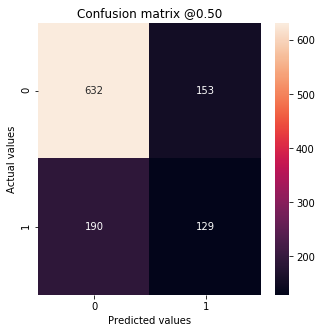

In [74]:
plot_cfm(y_test_gft, y_probas_test_gft)

In [75]:
print(classification_report(y_test_gft, y_pred_test_gft))

              precision    recall  f1-score   support

           0       0.77      0.81      0.79       785
           1       0.46      0.40      0.43       319

    accuracy                           0.69      1104
   macro avg       0.61      0.60      0.61      1104
weighted avg       0.68      0.69      0.68      1104



In [76]:
f1_gft = f1_score(y_test_gft, y_pred_test_gft, average='weighted')
print('Glove/FastText F1: %.2f' % f1_gft)

Glove/FastText F1: 0.68


In [77]:
auc_gft = roc_auc_score(y_test_gft, y_probas_test_gft)
print('Glove/FastText AUC: %.2f' % auc_gft)

Glove/FastText AUC: 0.68


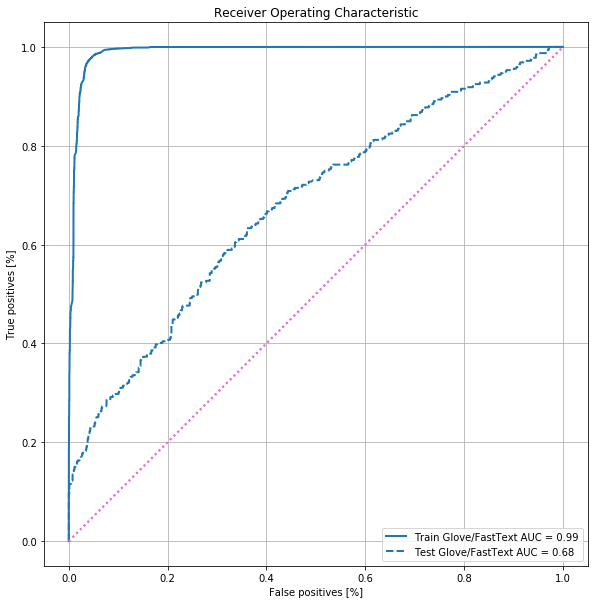

In [78]:
plot_roc("Train Glove/FastText", y_train_gft_sm, y_probas_train_gft, color = colors[0])
plot_roc("Test Glove/FastText", y_test_gft, y_probas_test_gft, color = colors[0], linestyle = '--')

***

**Summary**

***

In [79]:
# !pip install tabletext
import tabletext

table = [["Classifier", "F1", "AUC"],
        ["XGBoost w. TFIDF", f1_tfidf, auc_tfidf],
        ["XGBoost w. Word2Vec", f1_w2v, auc_w2v],
        ["XGBoost w. Glove/FastText", f1_gft, auc_gft],
        ]


print (tabletext.to_text(table))

┌───────────────────────────┬────────────────────┬────────────────────┐
│ Classifier                │ F1                 │ AUC                │
├───────────────────────────┼────────────────────┼────────────────────┤
│ XGBoost w. TFIDF          │ 0.6892596358013905 │  0.685484096399976 │
├───────────────────────────┼────────────────────┼────────────────────┤
│ XGBoost w. Word2Vec       │ 0.6976852546625566 │ 0.6808537827206838 │
├───────────────────────────┼────────────────────┼────────────────────┤
│ XGBoost w. Glove/FastText │ 0.6833246610782787 │ 0.6786534352974063 │
└───────────────────────────┴────────────────────┴────────────────────┘


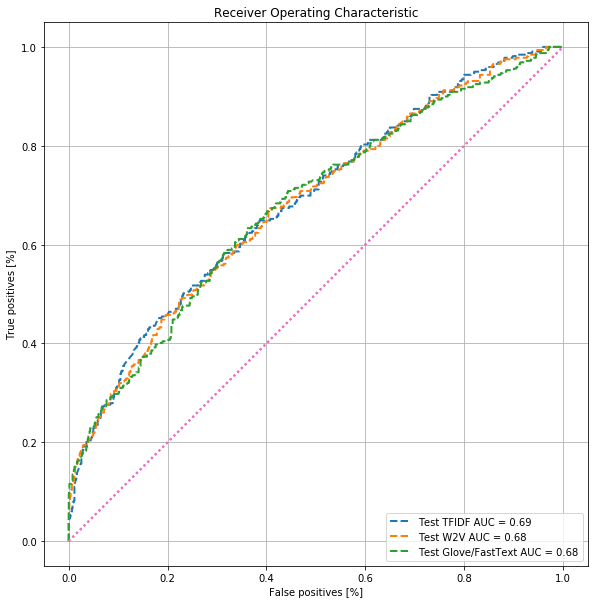

In [80]:
plot_roc("Test TFIDF", y_test_tfidf, y_probas_test_tfidf, color = colors[0], linestyle = '--')

plot_roc("Test W2V", y_test_w2v, y_probas_test_w2v, color = colors[1], linestyle = '--')

plot_roc("Test Glove/FastText", y_test_gft, y_probas_test_gft, color = colors[2], linestyle = '--')